In [1]:
from fastai.vision.all import *
from fastai.vision.core import *
from pathlib import Path

## Motivation
Recapping, in the last notebook we used PyTorch to suggest what breeds might be present in a mixed-breed dog. We used an off-the-shelf pretrained model with no manual tuning. 

In this notebook we'll again start from a high level, but we'll begin to tune some aspects of model-training manually.  In order to demonstrate the need for such tuning, we need a problem that is difficult enough that the most naive fine-tuning approach won't return an optimal result in a reasonable time. The goal for this notebook is to perform a proper binary classification task, using a dataset of images of two distinct dogs, Cricket and Widget.

Fluency in training Deep Learning models typically requires a lot of practice with a notably patient, experimental mindset. Consider this quote from Leslie Smith, US Naval researcher.
>The rise of deep learning (DL) has the potential to transform our future as a human race even morethan it already has and perhaps more than any other technology.  Deep learning has already created significant improvements in computer vision, speech recognition, and natural language processing,which has led to deep learning based commercial products being ubiquitous in our society and inour lives.  
>     In spite of this success, the application of deep neural networks remains a black art, often requiringyears  of  experience  to  effectively  choose  optimal  hyper-parameters,  regularization,  and  networkarchitecture, which are all tightly coupled.  Currently the process of setting the hyper-parameters,including designing the network architecture, requires expertise and extensive trial and error and isbased more on serendipity than science.  On the other hand, there is a recognized need to make theapplication of deep learning as easy as possible.  

*Leslie Smith, "A Disciplined Approach to Neural Network Hyper-Parameters: Part 1 - Learning Rate, Batch Size, Momentum, and Weight Decay"*

The fastai library fully embraces Smith's pioneering work, which over the past 5 years has sought to bring more science to the training process. Having said that, it remains true that a practitioner needs to develop intuition for how models train, and that this typically means trying many different approaches, and learning from failures. This notebook is a document of the beginning of one such practitioner's path.

### Establishing a Baseline
After the task was chosen, the dataset prepared, and an initial model trained it became clear that, given 100 examples of one dog and 28 examples of the other, this was far too easy a task for a modern Convolutional Neural Network (CNN)! The results were too good to provide a milieu for experimentation. At that point there were two choices:
1. Start over with a new task and dataset
2. Handicap the algorithm by, for example, limiting its depth or the number of examples it sees.  

For the sake of simplicity I chose the second option. (Additionally, learning how to deal with unbalanced data sets is a useful skill to practice). With that in mind, I first reduced the depth of the pretrained model to the minimum of 18 layers. The model still converged fairly quickly, so I began removing training images from one individual only - Widget. Once there were only 3 images of Widget remaining in the training set, the algorithm finally failed to achieve what could be considered an optimal result - though it was still quite good! This run serves as our baseline:

In [4]:
path = Path('./storage/data/CrickWidgeSolo')

A `DataBlock` is fastai's workhorse function for organizing a training loop at a fairly high level. There exist factory methods that organize training with even less code, but they aren't flexible, so the DataBlock is considered a good compromise. Beneath the DataBlock, fastai has a mid-level API consisting of *callbacks*. And of course the entire library is built upon PyTorch, which serves as another level for finer-grained control of training.

There are many different ways of splitting the data and applying labels. I chose to create nested folders whose names could be used by fastai to organize the data appropriately:

In [5]:
path.ls()

(#3) [Path('storage/data/CrickWidgeSolo/Train'),Path('storage/data/CrickWidgeSolo/.ipynb_checkpoints'),Path('storage/data/CrickWidgeSolo/Test')]

In [6]:
dogs = DataBlock(
        blocks=(ImageBlock, CategoryBlock), 
        get_items=get_image_files,
        splitter=GrandparentSplitter(train_name="Train", valid_name="Test"),
        get_y=parent_label,
        item_tfms=Resize(224))

A fastai `dataloaders` object wraps a PyTorch `DataLoader` object, which wraps a PyTorch `Dataset`, which takes raw images and transforms them into tensors... There are __many__ layers of abstractions in the stack.

We can view a training batch:

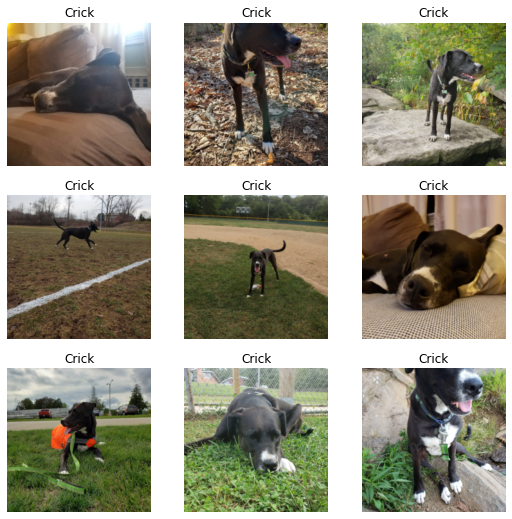

In [8]:
dls = dogs.dataloaders(path)
dls.show_batch()

At this point we're ready to create a __learner__ instance. We specify the data, the number of layers, and a metric, then train the model.

In [10]:
baseline_learner = cnn_learner(dls, resnet18, metrics=error_rate)
baseline_learner.fine_tune(40)

epoch,train_loss,valid_loss,error_rate,time
0,1.619071,1.138311,0.416667,00:30


epoch,train_loss,valid_loss,error_rate,time
0,1.451560,0.902839,0.395833,00:29
1,1.436712,0.649510,0.291667,00:28
2,1.337771,0.481056,0.187500,00:29
3,1.306241,0.395135,0.166667,00:29
4,1.303974,0.342149,0.145833,00:28
5,1.285783,0.312200,0.125000,00:28
6,1.230961,0.294404,0.104167,00:28
7,1.220068,0.253240,0.083333,00:28
8,1.201153,0.244848,0.104167,00:29
9,1.180997,0.266594,0.104167,00:28


Our **baseline error rate** is roughly **19%**.

In [11]:
interp = ClassificationInterpretation.from_learner(baseline_learner)

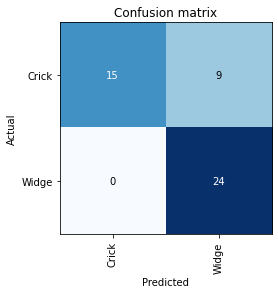

In [12]:
interp.plot_confusion_matrix()

Here we see that, in the face of a large class imbalance, the function that the neural network has settled on shows a strong bias towards selecting Widget, doing so for 33 of the 48 test images.

We can look at the images that the model was particularly 'confused' by, as indicated by giving a high confidence score (the second number above each image) to an incorrectly classified image.

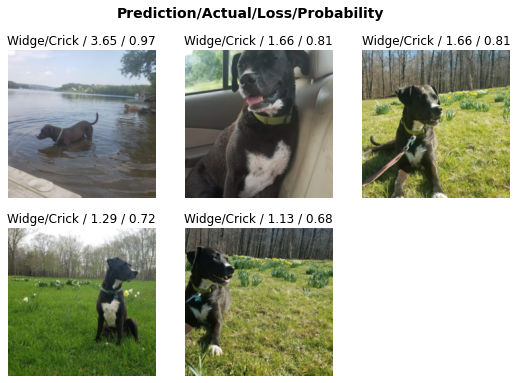

In [13]:
interp.plot_top_losses(5)

###  Fine-tuning - One level lower with the Learning Rate finder and 1-cycle policy

At this point we might wonder what our `cnn_learner.fine_tune()` did under the hood. Without going too far down the stack, we can get an idea by repeating the above training manually. First we need to discuss the concept of learning rate.

In a future report I'll discuss optimization - in particular Stochastic Gradient Descent (SGD). For now all we need to have in mind is that SGD is a convex optimization algorithm that uses the multivariate derivative, or gradient, to minimize a loss function. At each stage, the algorithm computes the gradient. The largest gradient gives the direction of the steepest descent toward a miniumum. SGD uses this information to decide where to 'step' next. The learning rate is a hyperparameter that tells SGD how 'big' a step to take, once it has a direction. The bigger the steps, the faster the model trains - which is not a small consideration. 

Too big a learning rate will cause the algorithm to not converge:

In [14]:
high_rate_learner = cnn_learner(dls, resnet18, metrics=error_rate)

In [15]:
high_rate_learner.fine_tune(2, base_lr=.3)

epoch,train_loss,valid_loss,error_rate,time
0,1.242706,10.892990,0.500000,00:29


epoch,train_loss,valid_loss,error_rate,time
0,2.231892,39.940022,0.500000,00:29
1,1.940975,296155.218750,0.500000,00:28
2,3.807943,88120.507812,0.500000,00:28


But too low a learning rate will be... too slow:

In [19]:
low_rate_learner = cnn_learner(dls, resnet18, metrics=error_rate)
low_rate_learner.fine_tune(10, base_lr=.00001)

epoch,train_loss,valid_loss,error_rate,time
0,1.410808,3.811144,0.500000,00:28


epoch,train_loss,valid_loss,error_rate,time
0,1.125786,3.129735,0.500000,00:28
1,1.406716,2.672610,0.500000,00:30
2,1.394853,2.303504,0.500000,00:28
3,1.385338,2.008206,0.479167,00:29
4,1.330237,1.805616,0.458333,00:29
5,1.348060,1.631268,0.458333,00:29
6,1.365992,1.478227,0.479167,00:29
7,1.371531,1.372967,0.479167,00:28
8,1.388711,1.270051,0.479167,00:29
9,1.381156,1.190179,0.479167,00:28


In 2015 Leslie Smith published a paper, 'Cyclical Learning Rates for Training Neural Networks', that represented a subsstantial breakthrough in understanding how best to tune the learning rate. The learning rate was considered the most important hyperparameter, and at the time progress had been steady but unsatisfactory. Smith hit on a novel idea: instead of assuming that the rate must change only monotonically over iterations, what if the rate was allowed to go up and down at various stages of training? He demonstrated that such a regime could not only work well, but spectacularly well. He found that any of a handful of periodic functions could push a model towards convergence much faster than previous methods. Since then Smith and others have further developed this idea, and it has become common practice. fastai's `learner.fine_tune()` uses this approach. Here we use fastai's `learner.lr_find()` method to find the optimal learning rate for the first cycle of training.

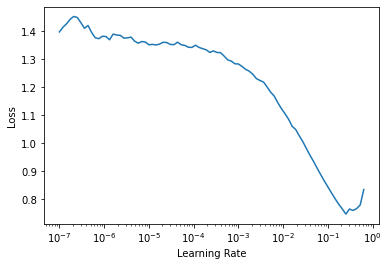

In [20]:
lr_learner = cnn_learner(dls, resnet18, metrics=error_rate)
lr_min, lr_steep = lr_learner.lr_find()

In [21]:
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

Minimum/10: 2.51e-02, steepest point: 1.32e-02


Now that we have the optimal learning rate, we can use it along with fastai's `learner.fit_one_cycle` to train the last layer of a newly-created instance of a pretrained model.

In [25]:
just_right = cnn_learner(dls, resnet18, metrics=error_rate)
just_right.fit_one_cycle(3, 2e-02)

epoch,train_loss,valid_loss,error_rate,time
0,1.343556,1.183698,0.458333,00:29
1,1.278789,2.820276,0.416667,00:29
2,1.877529,1.227588,0.291667,00:29


Recall that transfer learning works by starting with a set of parameters that have been arrived at by training on a (typically very large) dataset. To *transfer* the model we remove the final output layer and retrain it in the context of the domain of interest. `cnn_learner.fine_tune()` does just that, removing the last layer and retraining it. In order to do this manually in PyTorch and fastai, we need to first 'unfreeze' the model, which makes the parameters of the last layer mutable (trainable) while keeping the previous layers from the pretrained model frozen. 

In [26]:
just_right.unfreeze()

After `unfreeze`ing we need to find a new learning_rate, since we already used the prior one to train the first layer for 3 epochs.

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f51703b34c0>
Traceback (most recent call last):
  File "/opt/conda/envs/fastai/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/opt/conda/envs/fastai/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/opt/conda/envs/fastai/lib/python3.8/multiprocessing/process.py", line 147, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f51703b34c0>
Traceback (most recent call last):
  File "/opt/conda/envs/fastai/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/opt/conda/envs/fastai/lib/python3.8/site-packages/torch/utils/dat

SuggestedLRs(lr_min=0.04365158379077912, lr_steep=3.630780702224001e-05)

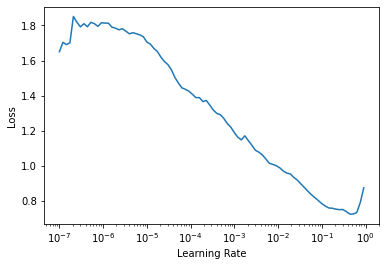

In [27]:
just_right.lr_find()

The output of the cell above is hidden for brevity. The values for the learning rate are:

> SuggestedLRs(lr_min=0.04365158379077912, lr_steep=3.630780702224001e-05)

This notebook cell was writter while waiting for `lr_find` _again._ The learning rate finder takes a long time to run. For that reason, after we've found the new learning rate we typically want to set it and then let it be adjusted automatically. `fit_one_cycle` and `fine_tune()` both provide that functionality. Here we specify a slice, with the first number representing the rate to train the first layer and the second number representing the rate for the last layer. fastai then interplotes values for the intermediate layers. This technique is called _Discriminative Learning Rates_.

In [ ]:
just_right.fit_one_cycle(fit_one_cycle(12, lr_max=slice(1e-5,13-3)))

## Improving on the Baseline

### Strategy 1: Image Augmentation

One strategy for dealing with training data that has too little information - wheter due to too few samples or too uniform samples - is to apply transformations to the input images, selectively increasing variance. PyTorch's linear algebra pedigree makes many standard transformations such as rotations, shears and reflections easy to apply to an image. 

In [29]:
dogs2 = DataBlock(
        blocks=(ImageBlock, CategoryBlock), 
        get_items=get_image_files,
        splitter=GrandparentSplitter(train_name="Train", valid_name="Test"),
        get_y=parent_label,
        item_tfms=Resize(224))

fastai then provides convenience methods for applying the transformations to a single image at a time, or to an entire batch. Here we apply a random cropping transformation to each image, while applying a stock set of deformation transformations to each batch

In [30]:
dogs2 = dogs2.new(item_tfms=RandomResizedCrop(128, min_scale=0.3),
               batch_tfms=aug_transforms())
dls_aug = dogs2.dataloaders(path)

We can see that the transformations have been applied:

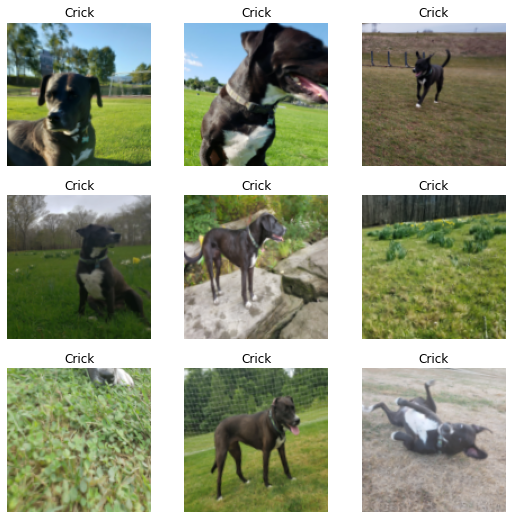

In [31]:
dls_aug.show_batch()

In [32]:
aug_learner = cnn_learner(dls_aug, resnet18, metrics=error_rate)
aug_learner.fine_tune(40)

epoch,train_loss,valid_loss,error_rate,time
0,1.107253,1.871725,0.625000,00:28


epoch,train_loss,valid_loss,error_rate,time
0,1.237705,1.584095,0.625000,00:27
1,1.110827,1.468977,0.583333,00:27
2,1.116355,1.293257,0.541667,00:27
3,1.128284,1.157968,0.520833,00:27
4,1.138416,0.963317,0.458333,00:27
5,1.101818,0.771690,0.416667,00:27
6,1.088875,0.678097,0.333333,00:27
7,1.081044,0.661120,0.375000,00:27
8,1.100060,0.683268,0.333333,00:27
9,1.117118,0.685514,0.333333,00:27


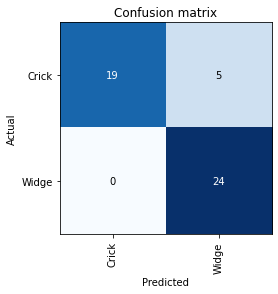

In [33]:
interp = ClassificationInterpretation.from_learner(aug_learner)
interp.plot_confusion_matrix()

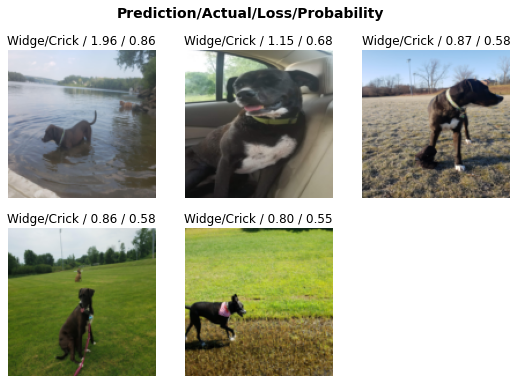

In [34]:
interp.plot_top_losses(5)

Augmentation improved on the baseline error rate by almost half, from roughly 19% to roughly **10%**.

### Strategy 2: Including Copies of the Existing Images

A second common strategy for making the most of limited data is to simply provide more instances of each of the samples you have! The fact that this should work is not obvious. But here we demonstrate that simply doubling the number of input images of Widget to 6 by duplicating the existing 3 images leads to a notable improvement over our baseline model.

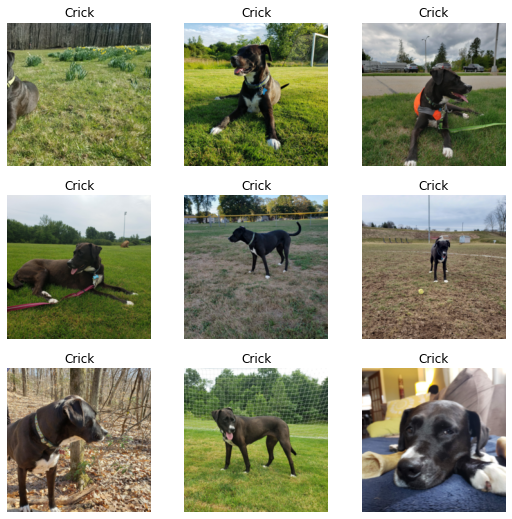

In [40]:
oversample = Path('./storage/data/CrickWidgeOversample')
dls_over = dogs.dataloaders(oversample)
dls_over.show_batch()

In [36]:
double_widge_learner = cnn_learner(dls_over, resnet18, metrics=error_rate)
double_widge_learner.fine_tune(30)

epoch,train_loss,valid_loss,error_rate,time
0,1.378253,1.421050,0.604167,00:27


epoch,train_loss,valid_loss,error_rate,time
0,1.147534,1.278825,0.562500,00:25
1,1.106987,1.143628,0.500000,00:24
2,1.098869,0.972563,0.479167,00:24
3,1.025644,0.831031,0.416667,00:25
4,1.032085,0.711570,0.354167,00:24
5,1.048339,0.608940,0.291667,00:25
6,1.046681,0.488369,0.187500,00:25
7,1.060807,0.385760,0.125000,00:25
8,1.058805,0.312948,0.125000,00:24
9,1.024362,0.307065,0.166667,00:24


This is pretty remarkable - just by duplicating of of the three images we've reduced our baseline error rate by roughly two-thirds, from 19% to around **6%**.

The model is still biased towards guessing Widget:

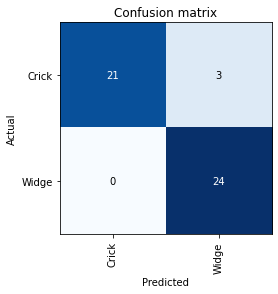

In [37]:
interp = ClassificationInterpretation.from_learner(double_widge_learner)
interp.plot_confusion_matrix()

### Strategy 3: Use More Layers
Now that we have these points of comparison, it's natural to start wondering how a network with more more layers would perform. So let's try:

In [39]:
layers50 = cnn_learner(dls, resnet50, metrics=error_rate)
layers50.fine_tune(40)

epoch,train_loss,valid_loss,error_rate,time
0,1.467481,1.438074,0.645833,00:27


epoch,train_loss,valid_loss,error_rate,time
0,1.266760,1.231477,0.708333,00:26
1,1.272054,1.156358,0.645833,00:25
2,1.246475,1.034436,0.562500,00:26
3,1.250846,0.864298,0.395833,00:25
4,1.246355,0.764632,0.333333,00:26
5,1.219695,0.625484,0.333333,00:25
6,1.194009,0.506256,0.208333,00:25
7,1.169154,0.507984,0.270833,00:25
8,1.127487,0.579996,0.354167,00:25
9,1.123673,0.588325,0.354167,00:25


An improvement from 6% to **4%** error. A point worth noting is that for each of these models, training was interrupted by the predetermined number of epochs, so it's possible that further improvements could have been gained if the models were allowed to run longer. In fact that is likely to be the case, considering that in each case the error rate, while flat, had still not begun to _increase_.

An interesting claimed feature of the 1-cycle policy is that it effectively amounts to a kind of regularization, and so in many circumstances models may be able to train at very small learning rates for many epochs without overfitting. 

As a last experiment, let's see how low we can get the error rate by combining the last three improvements we tried. We'll boost our total of training images of Widget to 48 by copying each image 16 times. Then we'll apply random cropping and deformation transformation to provide more variance for the network to work with. Lastly, we'll increase the number of parameters as compared to the baseline model, using a 34 layer resnet. It would be nice if we could try adjusting each of our three strategies one at a time, but training these models has been very time consuming, so we'll have to be satisfied with this 'kitchen sink' approach for now.

In [46]:
path_sink = Path('./storage/data/CrickWidgeOversample16x')

In [47]:
kitchen_sink = DataBlock(
        blocks=(ImageBlock, CategoryBlock), 
        get_items=get_image_files,
        splitter=GrandparentSplitter(train_name="Train", valid_name="Test"),
        get_y=parent_label,
        item_tfms=Resize(224))

In [48]:
kitchen_sink.new(item_tfms=RandomResizedCrop(128, min_scale=0.3),
               batch_tfms=aug_transforms())
kitchen_sink_dls = kitchen_sink.dataloaders(path_sink)

In [49]:
sink_learner = cnn_learner(kitchen_sink_dls, resnet34, metrics=error_rate)
sink_learner.fine_tune(15)

epoch,train_loss,valid_loss,error_rate,time
0,1.437102,0.720785,0.312500,00:29


epoch,train_loss,valid_loss,error_rate,time
0,0.537681,0.520367,0.229167,00:29
1,0.400770,0.432188,0.229167,00:29
2,0.331013,0.330697,0.187500,00:32
3,0.278526,0.267620,0.125000,00:34
4,0.221273,0.149693,0.062500,00:34
5,0.183446,0.085294,0.041667,00:32
6,0.155075,0.067999,0.020833,00:28
7,0.133736,0.075377,0.020833,00:28
8,0.116606,0.089899,0.020833,00:28
9,0.102826,0.109155,0.020833,00:28


At **2%**, this is our lowest error rate - and the model converged very quickly. 

What is perhaps more interesting is that the model seems to have begun to overfit, in contradistinction to our discussion above about these models having some built-in immunity to overfitting. (When this same model was run for 50 epochs, the error rate continued to climb monotonically, indicating true overfitting - as opposed to a temporary rise in error rate, which is actually expected with the 1-cycle policy). An initial hypothesis is that the inclusion of so many copies - 16 - of the Widget images allowed the parameters to essentially 'memorize' these images, even if they had been augmented.

## Input Data - How Low Can You Go?
We've seen that even three training images of one class is enough to have success on what is, by 2020 standards, an admittedly easy task. A last natural question is - what if we only had **one** image of a given class. Let's see if we can get a resnet to fail. The input for this network is one image of Widget, and 10 x 8 images of Cricket (8 copies of 10 unique images - again to make it a bit harder. Note, we only have 11 distinct images, and we'll be testing the model on 48 unseen ones!

In [54]:
path_small = Path('./storage/data/CrickWidgeSmallSet')
small = DataBlock(
        blocks=(ImageBlock, CategoryBlock), 
        get_items=get_image_files,
        splitter=GrandparentSplitter(train_name="Train", valid_name="Test"),
        get_y=parent_label,
        item_tfms=Resize(224))
dls_small = small.dataloaders(path_small)

If we look at the error_rate column below, we can see the 'cycling' pattern of the 1-Cycle policy - the error rate indeed cycles periodically, presumably in response to the learning rate. The model performs worse than any other we trained, but seeing as it had such little unique data, achieving a best accuracy rate of over 80% is surprising.

In [55]:
layers50_small_data = cnn_learner(dls_small, resnet50, metrics=error_rate)
layers50_small_data.fine_tune(50)

epoch,train_loss,valid_loss,error_rate,time
0,1.648304,0.922408,0.500000,00:32


epoch,train_loss,valid_loss,error_rate,time
0,1.364623,0.839678,0.458333,00:33
1,1.399333,0.758046,0.458333,00:31
2,1.367424,0.718725,0.416667,00:33
3,1.356962,0.716804,0.437500,00:34
4,1.308368,0.783516,0.520833,00:32
5,1.249773,0.810510,0.437500,00:33
6,1.253259,0.757568,0.416667,00:33
7,1.250791,0.662849,0.354167,00:32
8,1.245187,0.554032,0.312500,00:32
9,1.236038,0.471091,0.250000,00:33
